In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nest_asyncio
import dateutil.parser
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
from cryptography.hazmat.primitives import serialization

# Import the provided client library
from clients.clients import KalshiHttpClient, Environment

# Plotting style
sns.set_theme(style="darkgrid")
%matplotlib inline

# --- CONFIGURATION ---
# Load your keys (Assumes you have a kalshi_key.txt or similar, or paste them here)
# NEVER share this notebook with your private keys hardcoded if you publish it.

# Initialize Client
try:
	nest_asyncio.apply()

	load_dotenv()
	env = Environment.PROD
	KEYID = os.getenv('KEYID')
	KEYFILE = os.getenv('KEYFILE')
	try:
		with open(KEYFILE, "rb") as key_file:
			private_key = serialization.load_pem_private_key(
				key_file.read(),
				password=None
			)
	except FileNotFoundError:
		raise FileNotFoundError(f"Private key file not found at {KEYFILE}")
	except Exception as e:
		raise Exception(f"Error loading private key: {str(e)}")

	client = KalshiHttpClient(
		key_id=KEYID,
		private_key=private_key,
		environment=env
	)
	print("✅ Client initialized successfully.")
except Exception as e:
	print(f"❌ Error initializing client: {e}")

✅ Client initialized successfully.


In [3]:

def fetch_market_candles(market_tickers, limit=1000):
    """Fetches and caches candlestick data to avoid repeated API calls."""
    out = []

    for i, ticker in enumerate(market_tickers):
        cache = []

        print(f"({i+1}/{len(market_tickers)}) Fetching market data for Series: {ticker}...")
        try:
            response = client.get_markets(
                series_ticker=ticker,
                status="settled",
                limit=limit
            )
        except Exception as e:
            print(f"❌ Failed to fetch markets for {ticker}: {e}")
            continue

        if 'markets' not in response:
            print(f"No markets found for {ticker}.")
            continue # Changed return [] to continue so other tickers process

        markets = response['markets']
        print(f"Found {len(markets)} markets. Fetching candle data...")

        for i, market in enumerate(markets):
            print(f"({i+1}/{len(markets)}) Market: {market['ticker']}")
            # A. Get Game Start Time
            end_ts = None
            for key in ['close_ts', 'expiration_ts', 'latest_expiration_ts', 'close_time']:
                if market.get(key):
                    val = market[key]
                    if isinstance(val, int):
                        end_ts = val
                        break
                    elif isinstance(val, str):
                        try:
                            # Ensure dateutil is imported
                            end_ts = int(dateutil.parser.parse(val).timestamp())
                            break
                        except Exception as e:
                            # print(f"Date parse error: {e}") 
                            continue

            if end_ts is None:
                # print(f"Skipping market {market['ticker']} - No end timestamp found")
                continue

            # B. Define Window (48h Pre-Game)
            # Note: This logic assumes you want data ending 3 hours before close
            start_ts = end_ts - (60 * 60 * 48)

            try:
                resp = client.get_market_candlesticks(
                    series_ticker=ticker, 
                    ticker=market['ticker'],
                    start_ts=start_ts,
                    end_ts=end_ts,
                    period_interval=1
                )
                
                candles = resp.get('candlesticks', [])

                # C. Filter Pre-Game Only
                if candles:
                    cache.append({
                        "ticker": market['ticker'],
                        "candles": candles
                    })
                # else:
                #     print(f"No candles returned for {market['ticker']}")

            except Exception as e:
                # Print the error instead of silently continuing
                print(f"❌ Error fetching candles for {market['ticker']}: {e}")
                continue
        
        out.append(cache)

    total_markets = sum(len(x) for x in out)
    print(f"Successfully cached data for {total_markets} markets from {len(out)} tickers.")
    return out

In [2]:
# Example usage
data = fetch_market_candles(["KXNBAGAME", "KXNHLGAME", "KXMLBGAME", "KXNFLGAME"])
print(f"Returned {len(data)} items")

(1/4) Fetching market data for Series: KXNBAGAME...
ERROR! Session/line number was not unique in database. History logging moved to new session 261


KeyboardInterrupt: 

In [14]:
print(data[0][0]['candles'][0]['yes_bid'])

{'close': 32, 'close_dollars': '0.3200', 'high': 32, 'high_dollars': '0.3200', 'low': 32, 'low_dollars': '0.3200', 'open': 32, 'open_dollars': '0.3200'}


In [50]:
def find_max_scalp_potential(market):
    ticker = market['ticker']
    max_price = 0
    open_price = market['candles'][0]['yes_ask']['close']
    for candle in market['candles'][1:]:
        yes_bid = candle.get('yes_bid')
        if yes_bid and yes_bid.get('high'):
            if yes_bid['high'] > max_price:
                max_price = yes_bid['high']

    profit_potential = max_price - open_price
    return {
        "ticker": ticker.split('-')[0],
        "market": ticker.split('-')[1],
	    "team":"".join(ticker.split('-')[2] + "-" + ticker.split('-')[0]),
        "open_price": open_price,
        "max_exit_price": max_price,
        "profit_potential": profit_potential,
        "win_5c": profit_potential >= 5,
        "win_10c": profit_potential >= 10
    }

In [51]:
tmp = []
for t in data:
	for j in t:
		tmp.append(find_max_scalp_potential(j))
df = pd.DataFrame(tmp)
df.head(6)

,ticker,market,team,open_price,max_exit_price,profit_potential,win_5c,win_10c
0,KXNBAGAME,25DEC01PHXLAL,PHX-KXNBAGAME,39,35,-4,False,False
1,KXNBAGAME,25DEC01PHXLAL,LAL-KXNBAGAME,69,73,4,False,False
2,KXNBAGAME,25DEC01DALDEN,DEN-KXNBAGAME,85,85,0,False,False
3,KXNBAGAME,25DEC01DALDEN,DAL-KXNBAGAME,19,20,1,False,False
4,KXNBAGAME,25DEC01HOUUTA,UTA-KXNBAGAME,38,23,-15,False,False
5,KXNBAGAME,25DEC01HOUUTA,HOU-KXNBAGAME,86,87,1,False,False


In [52]:
df.columns

Index(['ticker', 'market', 'team', 'open_price', 'max_exit_price',
       'profit_potential', 'win_5c', 'win_10c'],
      dtype='object')


==================== REPORT: AGGREGATE (All Tickers) ====================


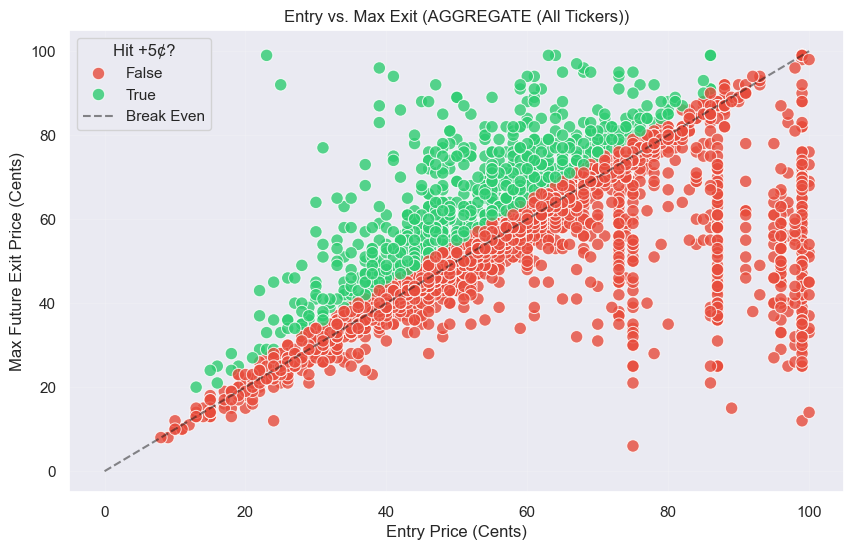

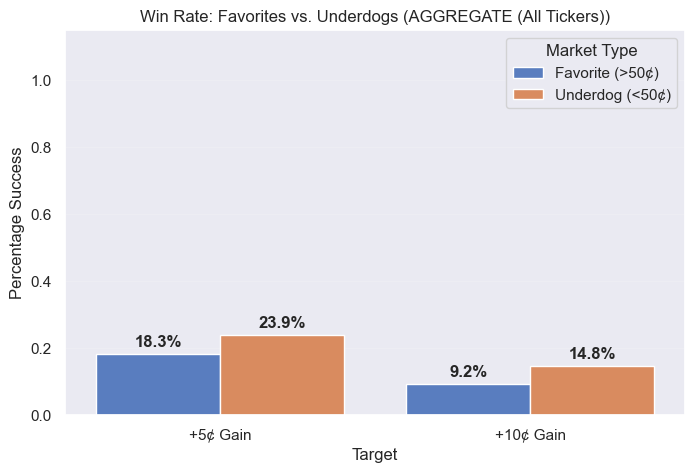

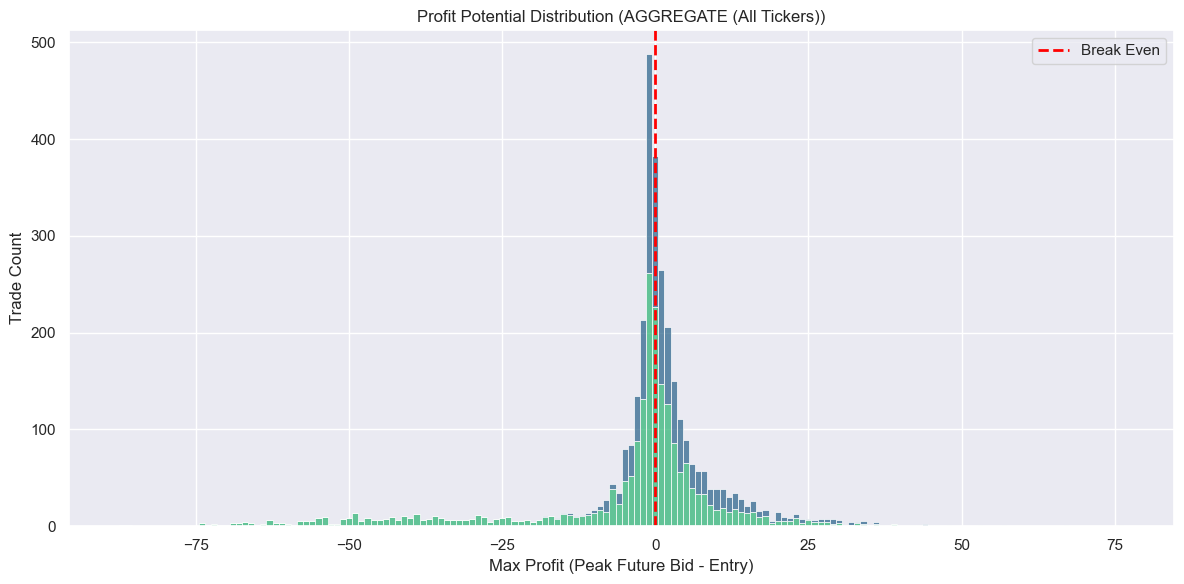


==================== REPORT: Ticker: KXNBAGAME ====================


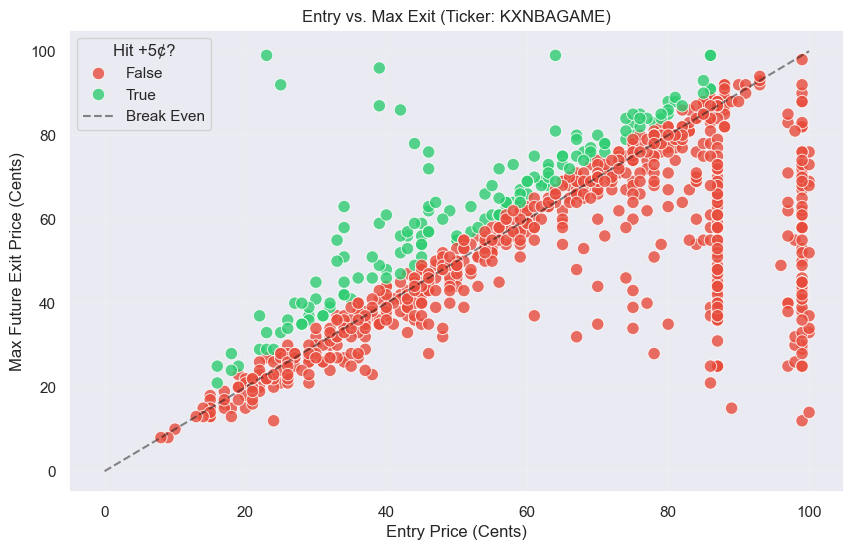

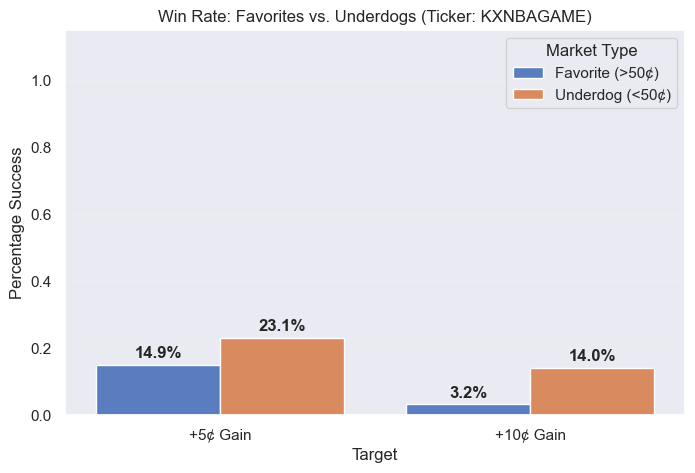

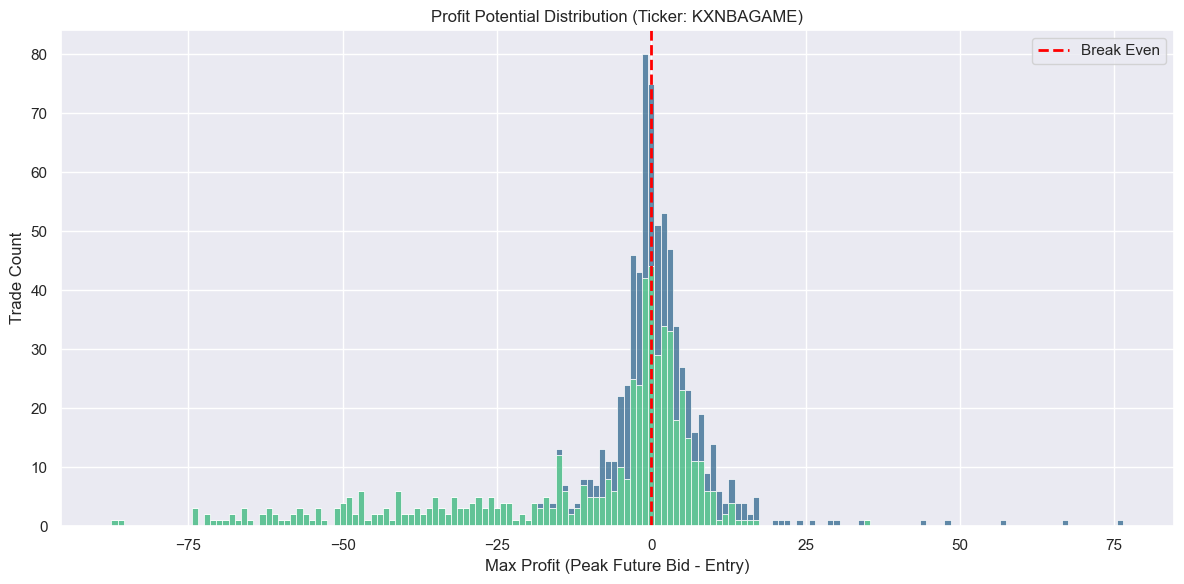


==================== REPORT: Ticker: KXNHLGAME ====================


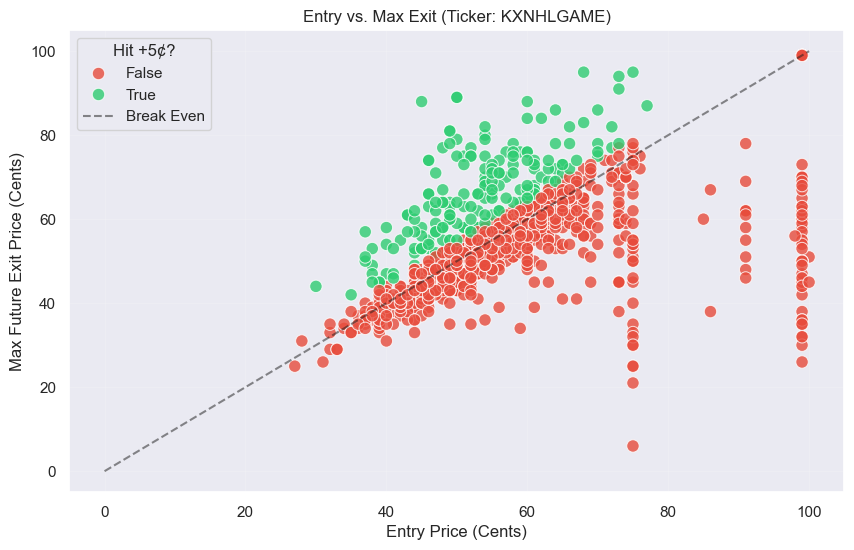

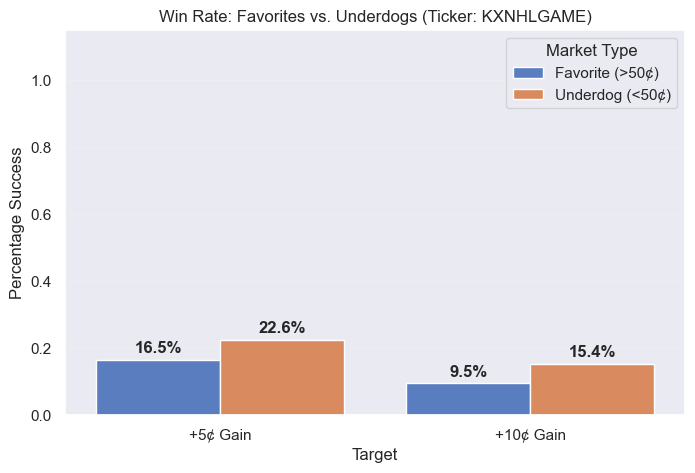

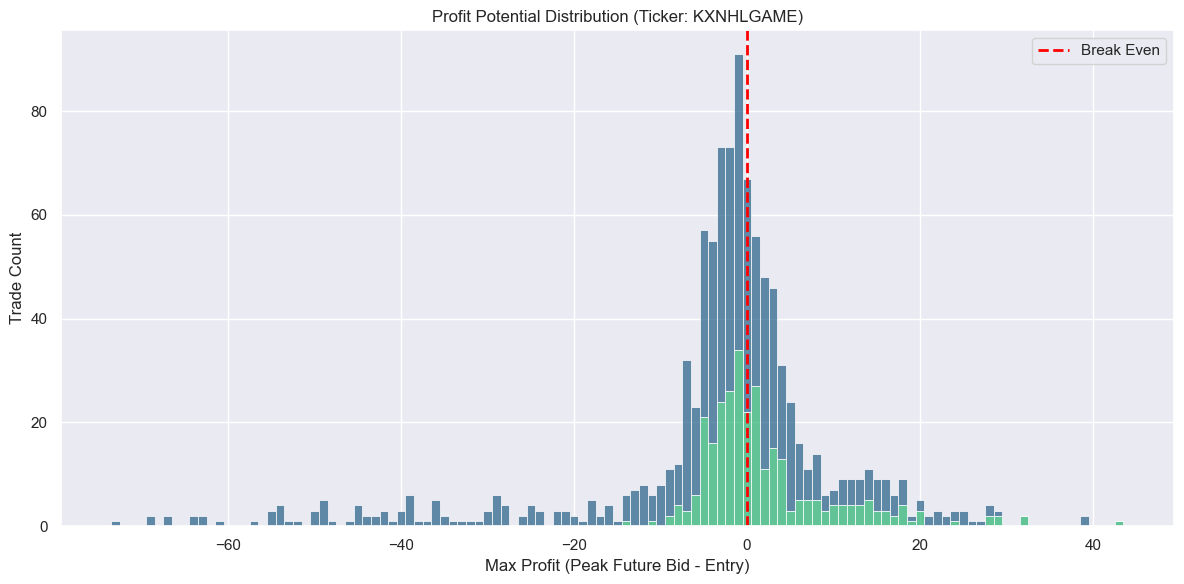


==================== REPORT: Ticker: KXMLBGAME ====================


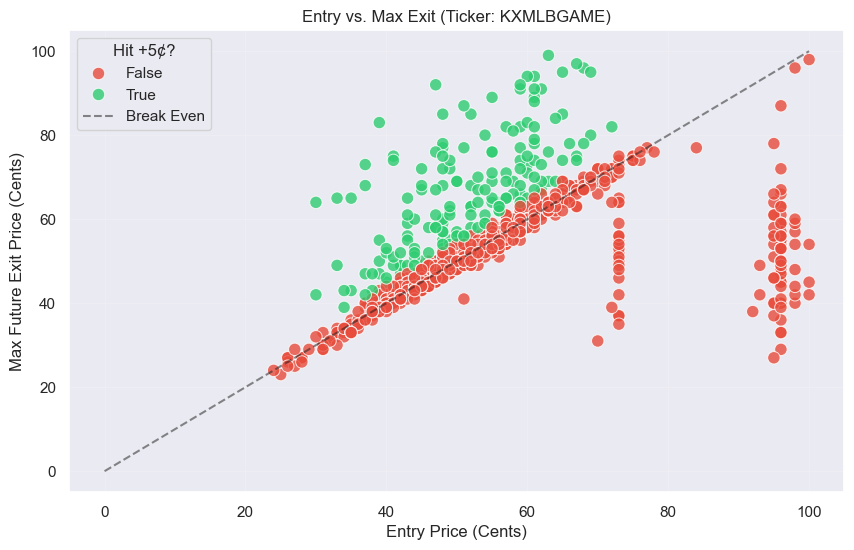

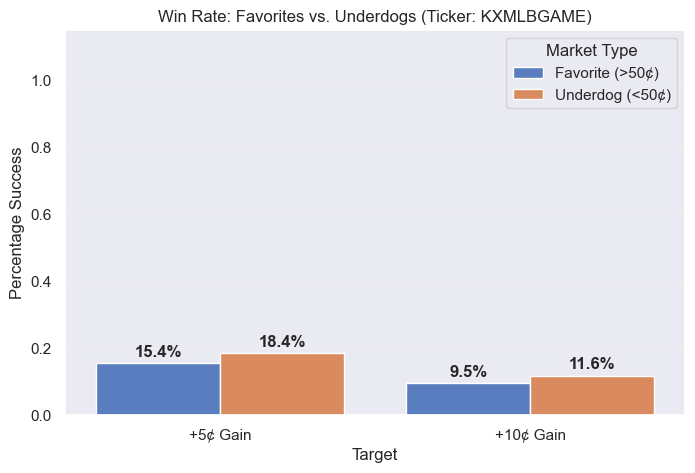

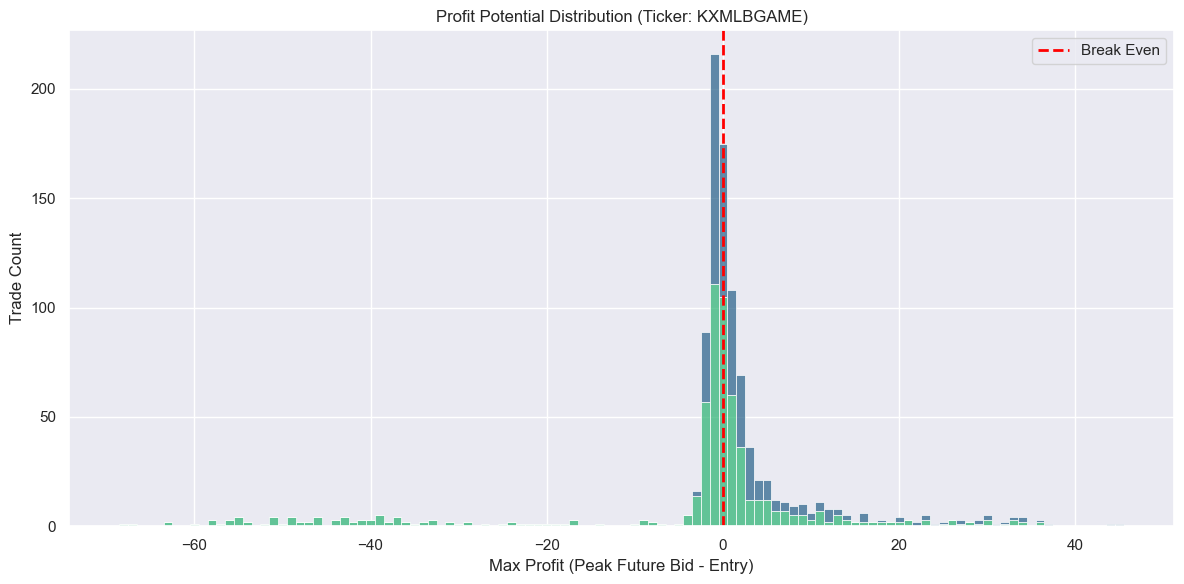


==================== REPORT: Ticker: KXNFLGAME ====================


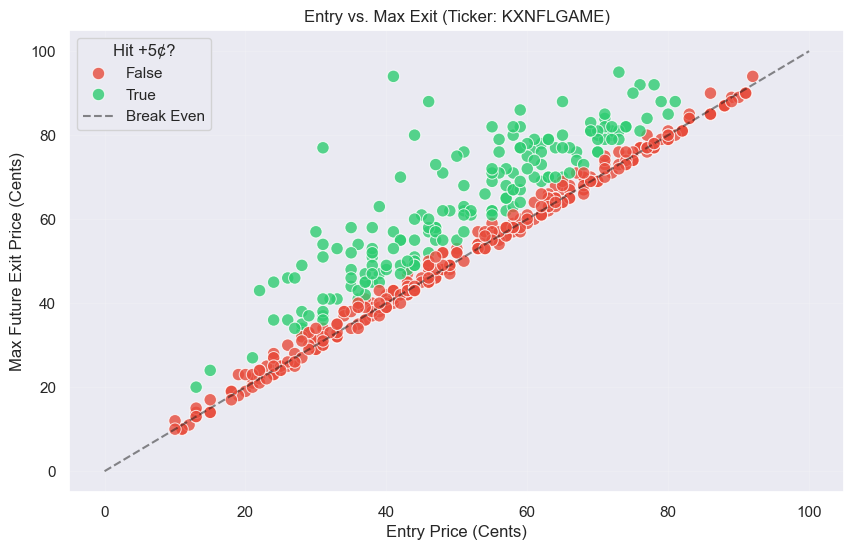

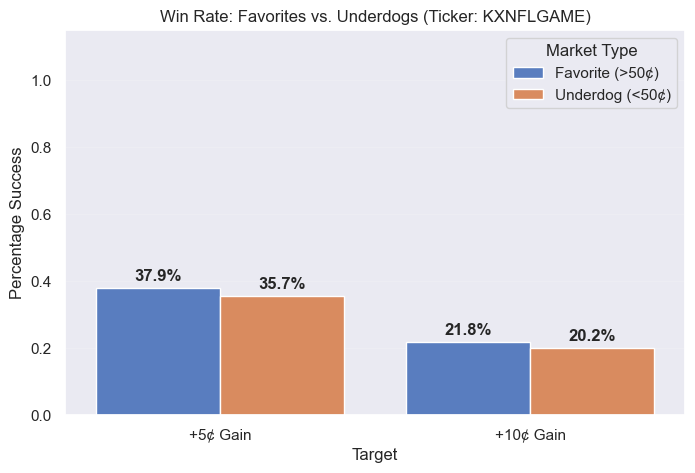

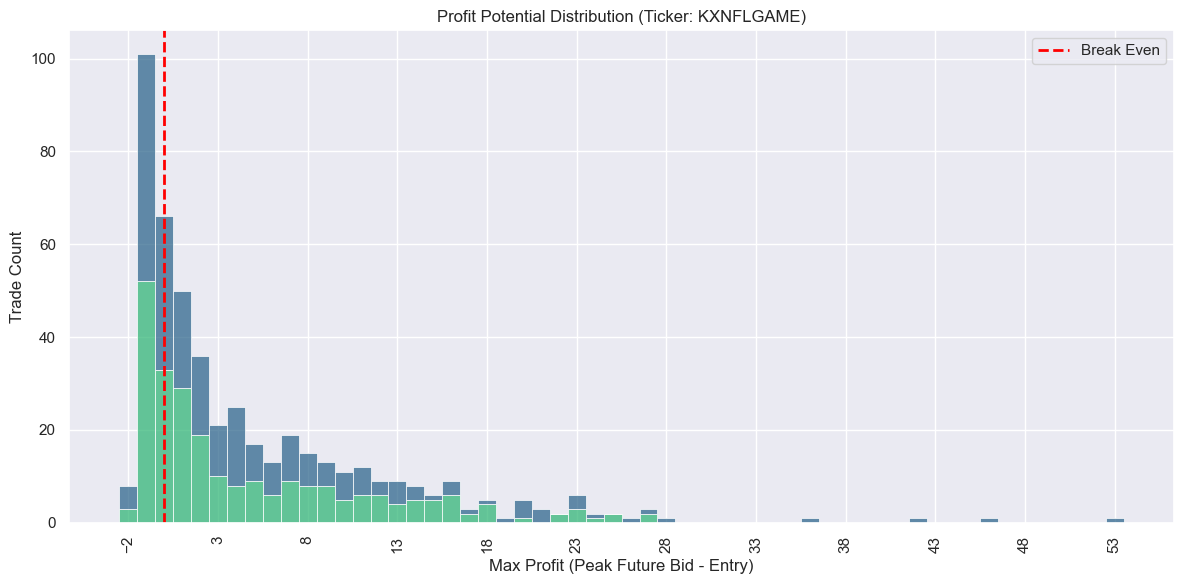

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def generate_scalping_report(data, title_label):
    """
    Generates Scatter, Win Rate, and Distribution plots for a given dataframe.
    """
    if data.empty:
        print(f"Skipping {title_label}: No data available.")
        return

    # Ensure we are working with a copy
    df_plot = data.copy()

    # 1. Define Favorites vs Underdogs if not already present
    if 'type' not in df_plot.columns:
        df_plot['type'] = np.where(df_plot['open_price'] >= 50, 'Favorite (>50¢)', 'Underdog (<50¢)')

    print(f"\n{'='*20} REPORT: {title_label} {'='*20}")

    # -----------------------------
    # PLOT 1: SCATTER PLOT
    # -----------------------------
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_plot,
        x="open_price",
        y="max_exit_price",
        hue="win_5c",
        palette={True: "#2ecc71", False: "#e74c3c"},
        s=80,
        alpha=0.8
    )
    plt.plot([0, 100], [0, 100], 'k--', label="Break Even", alpha=0.5)

    plt.title(f"Entry vs. Max Exit ({title_label})")
    plt.xlabel("Entry Price (Cents)")
    plt.ylabel("Max Future Exit Price (Cents)")
    plt.legend(title="Hit +5¢?")
    plt.grid(True, alpha=0.15)
    plt.show()

    # -----------------------------
    # PLOT 2: WIN RATE BAR CHART
    # -----------------------------
    win_rates = df_plot.groupby('type')[['win_5c', 'win_10c']].mean().reset_index()

    if not win_rates.empty:
        win_rates = win_rates.melt(id_vars='type', var_name='Target', value_name='Win Rate')
        win_rates['Target'] = win_rates['Target'].replace({'win_5c': '+5¢ Gain', 'win_10c': '+10¢ Gain'})

        plt.figure(figsize=(8, 5))
        ax = sns.barplot(data=win_rates, x="Target", y="Win Rate", hue="type", palette="muted")

        plt.ylim(0, 1.15)
        plt.title(f"Win Rate: Favorites vs. Underdogs ({title_label})")
        plt.ylabel("Percentage Success")
        plt.grid(axis='y', alpha=0.15)

        # --- FIX: Changed fontWeight to fontweight ---
        for container in ax.containers:
            ax.bar_label(container, fmt='{:.1%}', padding=3, fontweight='bold')

        plt.legend(title="Market Type")
        plt.show()
    else:
        print(f"  > Not enough data to generate Win Rate chart for {title_label}")

    # -----------------------------
    # PLOT 3: DISTRIBUTION HISTOGRAM
    # -----------------------------
    plt.figure(figsize=(12, 6))

    min_val = int(df_plot['profit_potential'].min())
    max_val = int(df_plot['profit_potential'].max())

    sns.histplot(
        data=df_plot,
        x='profit_potential',
        discrete=True,
        hue='type',
        multiple="stack",
        palette="viridis",
        edgecolor="white",
        linewidth=0.5
    )

    plt.axvline(0, color='red', linestyle='--', label="Break Even", linewidth=2)
    plt.title(f"Profit Potential Distribution ({title_label})")
    plt.xlabel("Max Profit (Peak Future Bid - Entry)")
    plt.ylabel("Trade Count")

    # Logic to prevent overcrowded x-axis labels
    if max_val - min_val < 50:
        plt.xticks(np.arange(min_val, max_val + 1, 1), rotation=90)
    elif max_val - min_val < 100:
        plt.xticks(np.arange(min_val, max_val + 1, 5), rotation=90)

    plt.legend()
    plt.tight_layout()
    plt.show()


# ==========================================
# MAIN EXECUTION LOOP
# ==========================================

if not df.empty:
    # 1. Generate Aggregate Report
    generate_scalping_report(df, "AGGREGATE (All Tickers)")

    # 2. Generate Individual Reports
    unique_tickers = df['ticker'].unique()

    if len(unique_tickers) > 1:
        for ticker in unique_tickers:
            ticker_df = df[df['ticker'] == ticker]
            generate_scalping_report(ticker_df, f"Ticker: {ticker}")
else:
    print("DataFrame is empty. No plots generated.")

Running delayed entry simulation...
Simulation complete. Generated 25596 hypothetical trades.


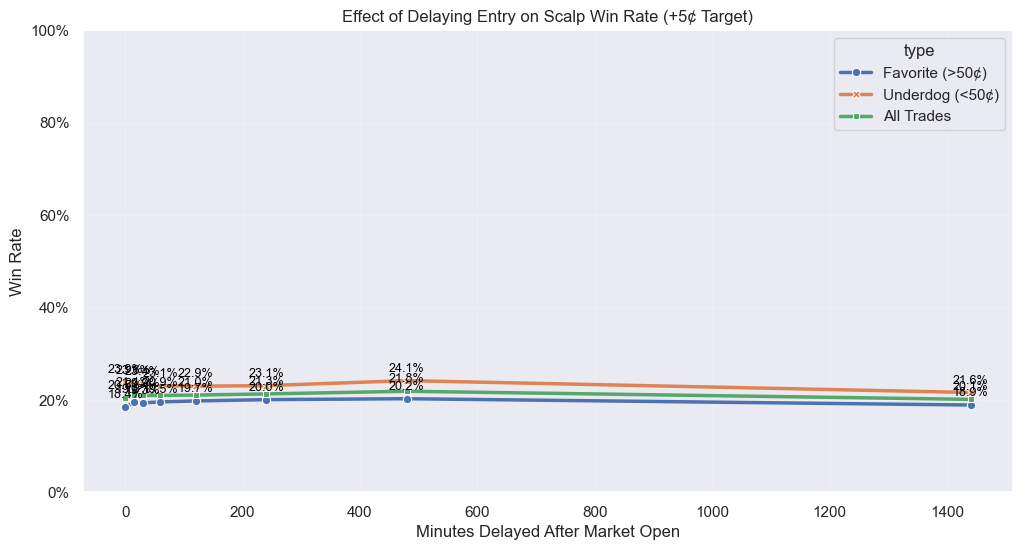

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def analyze_delayed_entry(market, delay_minutes=0):
    """
    Simulates a trade entry after a specific delay from the first available data point.
    """
    candles = market.get('candles', [])
    if not candles or len(candles) < 2:
        return None

    # 1. Determine Start and Target Time
    start_ts = candles[0]['end_period_ts']
    target_ts = start_ts + (delay_minutes * 60) # Convert minutes to seconds

    # 2. Find the Candle occurring at or after the Target Time
    entry_candle = None
    entry_idx = -1

    for i, candle in enumerate(candles):
        if candle['end_period_ts'] >= target_ts:
            entry_candle = candle
            entry_idx = i
            break

    # If no candle found (market ended) or it's the very last candle, skip
    if entry_candle is None or entry_idx >= len(candles) - 1:
        return None

    # 3. Get Entry Price (Close of the delayed candle)
    entry_price = entry_candle['yes_ask'].get('close', 0)

    # Filter invalid entries (0 or 100 usually indicate dead/settled markets)
    if entry_price <= 0 or entry_price >= 100:
        return None

    # 4. Determine Market Type (Favorite vs Underdog)
    m_type = 'Favorite (>50¢)' if entry_price >= 50 else 'Underdog (<50¢)'

    # 5. Check Future Max Exit
    future_candles = candles[entry_idx+1:]
    future_highs = [c['yes_bid'].get('high', 0) for c in future_candles]

    if not future_highs:
        return None

    max_exit = max(future_highs)
    profit = max_exit - entry_price

    return {
        'ticker': market['ticker'],
        'delay_minutes': delay_minutes,
        'type': m_type,
        'entry_price': entry_price,
        'max_exit': max_exit,
        'profit': profit,
        'win_5c': profit >= 5,
        'win_10c': profit >= 10
    }

# --- RUN SIMULATION ---
# Define delays to test (in minutes): 0, 15m, 30m, 1h, 2h, 4h
delays_to_test = [0, 15, 30, 60, 120, 240, 480, 1440]
results = []

print("Running delayed entry simulation...")

# Assuming 'data' variable exists from your previous fetch
for delay in delays_to_test:
    for series in data: # series is a list of markets
        for market in series:
            res = analyze_delayed_entry(market, delay)
            if res:
                results.append(res)

df_delay = pd.DataFrame(results)

if not df_delay.empty:
    print(f"Simulation complete. Generated {len(df_delay)} hypothetical trades.")

    # --- VISUALIZATION ---

    # 1. Aggregate Win Rate by Delay
    # Group by Delay and Type, calculate mean of win_5c
    stats = df_delay.groupby(['delay_minutes', 'type'])['win_5c'].mean().reset_index()

    # Also calculate global average per delay
    global_stats = df_delay.groupby('delay_minutes')['win_5c'].mean().reset_index()
    global_stats['type'] = 'All Trades'

    # Combine for plotting
    plot_data = pd.concat([stats, global_stats], ignore_index=True)

    plt.figure(figsize=(12, 6))

    # Line Plot
    sns.lineplot(
        data=plot_data,
        x='delay_minutes',
        y='win_5c',
        hue='type',
        style='type',
        markers=True,
        dashes=False,
        linewidth=2.5,
        palette="deep"
    )

    # Styling
    plt.title("Effect of Delaying Entry on Scalp Win Rate (+5¢ Target)")
    plt.xlabel("Minutes Delayed After Market Open")
    plt.ylabel("Win Rate")
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.2)

    # Format Y-axis as percentage
    from matplotlib.ticker import PercentFormatter
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

    # Add data labels
    for i, row in plot_data.iterrows():
        plt.text(
            row['delay_minutes'],
            row['win_5c'] + 0.02,
            f"{row['win_5c']:.1%}",
            ha='center',
            fontsize=9,
            color='black'
        )

    plt.show()

else:
    print("No valid trades generated. Check data source.")

Paired 3328 trades with their opponents.


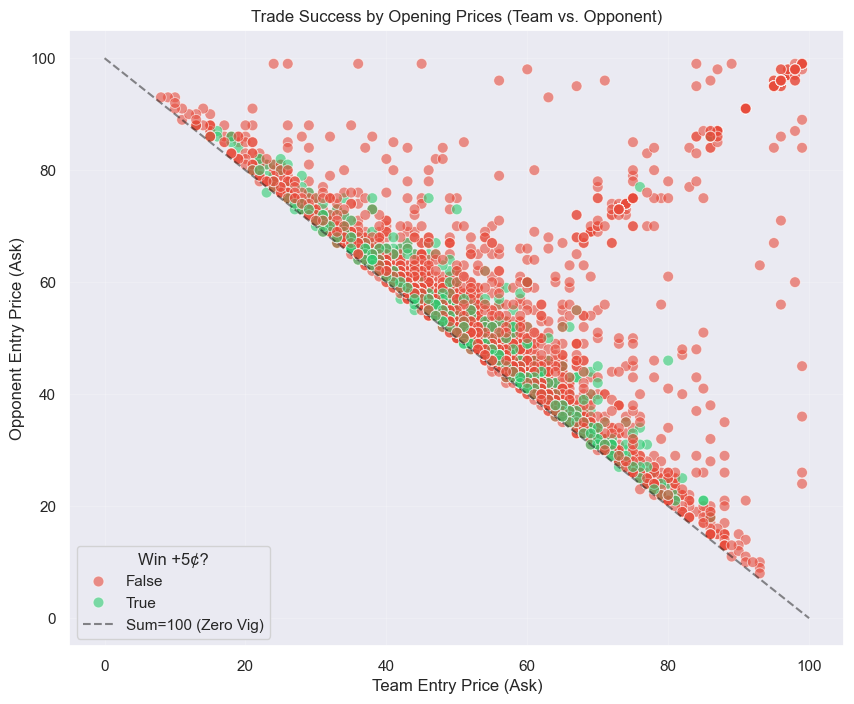

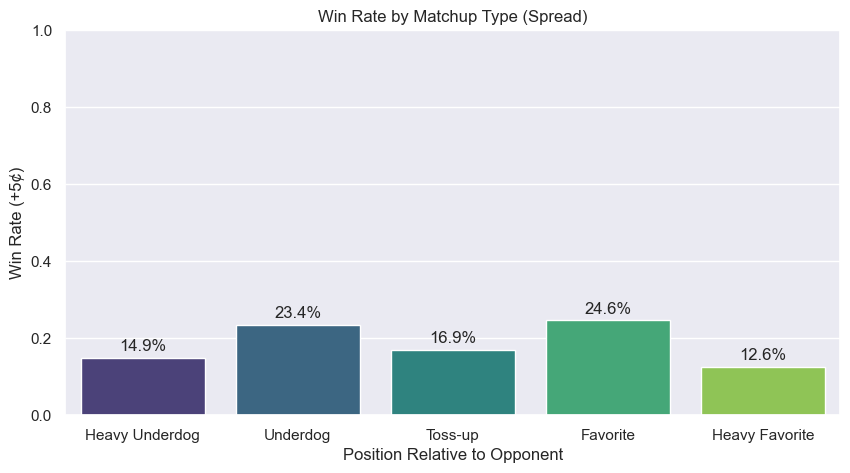

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Helper to parse Event ID and Prices
def get_market_metrics(market):
    ticker = market['ticker']
    parts = ticker.split('-')

    # Validation: Ensure ticker format is Series-Event-Team
    if len(parts) < 3: return None

    series_id = parts[0]      # e.g. KXNBAGAME
    event_id = parts[1]       # e.g. 25DEC01PHXLAL (The common link)
    team = parts[2]           # e.g. PHX

    candles = market.get('candles', [])
    if not candles or len(candles) < 2: return None

    # Entry: Ask Close of first candle
    # (Using Ask because that is the realistic buy price)
    entry_val = candles[0].get('yes_ask', {}).get('close', 0)

    # Filter dead/invalid markets
    if entry_val <= 0 or entry_val >= 100: return None

    # Exit: Bid High of subsequent candles
    future_highs = [c['yes_bid'].get('high', 0) for c in candles[1:]]
    if not future_highs: return None

    max_exit = max(future_highs)
    profit = max_exit - entry_val

    return {
        'ticker': ticker,
        'event_id': event_id,
        'team': team,
        'open_price': entry_val,
        'max_exit': max_exit,
        'profit': profit,
        'win_5c': profit >= 5
    }

# 2. Process all data
# Flatten the 'data' list (which is a list of lists)
all_markets = [m for sublist in data for m in sublist]
parsed_data = []

for m in all_markets:
    res = get_market_metrics(m)
    if res:
        parsed_data.append(res)

df_base = pd.DataFrame(parsed_data)

if not df_base.empty:
    # 3. Pair Opponents
    # Merge the dataframe with itself on 'event_id' to align opponents side-by-side
    df_merged = pd.merge(df_base, df_base, on='event_id', suffixes=('', '_opp'))

    # Filter out self-matches (Team A vs Team A)
    # We only want rows where I am 'team' and opponent is 'team_opp'
    df_paired = df_merged[df_merged['team'] != df_merged['team_opp']].copy()

    print(f"Paired {len(df_paired)} trades with their opponents.")

    # 4. Visualization
    plt.figure(figsize=(10, 8))

    # Scatter Plot: My Open vs Opponent Open
    # Green dots = Win, Red dots = Loss
    sns.scatterplot(
        data=df_paired,
        x='open_price',
        y='open_price_opp',
        hue='win_5c',
        palette={True: '#2ecc71', False: '#e74c3c'}, # Bright Green/Red
        alpha=0.6,
        s=60
    )

    # Add a reference line for "Perfect Efficiency" (Price A + Price B = 100)
    x_line = np.linspace(0, 100, 100)
    y_line = 100 - x_line
    plt.plot(x_line, y_line, 'k--', label='Sum=100 (Zero Vig)', alpha=0.5)

    plt.title("Trade Success by Opening Prices (Team vs. Opponent)")
    plt.xlabel("Team Entry Price (Ask)")
    plt.ylabel("Opponent Entry Price (Ask)")
    plt.legend(title="Win +5¢?")
    plt.grid(True, alpha=0.2)
    plt.show()

    # 5. Bar Chart: Win Rate by "Tightness" of Match
    # Define 'Spread' as abs(My Price - Opp Price)
    # Low spread = Tight game (e.g., 52 vs 48). High spread = Blowout (e.g., 80 vs 20).
    df_paired['price_spread'] = (df_paired['open_price'] - df_paired['open_price_opp'])

    # Bin the spread into categories
    # < -50: I am heavy underdog
    # -50 to -10: I am moderate underdog
    # -10 to 10: Toss-up
    # 10 to 50: I am moderate favorite
    # > 50: I am heavy favorite
    bins = [-100, -50, -10, 10, 50, 100]
    labels = ['Heavy Underdog', 'Underdog', 'Toss-up', 'Favorite', 'Heavy Favorite']
    df_paired['match_type'] = pd.cut(df_paired['price_spread'], bins=bins, labels=labels)

    win_rate_by_type = df_paired.groupby('match_type')['win_5c'].mean().reset_index()

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=win_rate_by_type, x='match_type', y='win_5c', palette='viridis')

    plt.title("Win Rate by Matchup Type (Spread)")
    plt.xlabel("Position Relative to Opponent")
    plt.ylabel("Win Rate (+5¢)")
    plt.ylim(0, 1.0)

    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1%}', padding=3)

    plt.show()

else:
    print("No paired data available.")

Analyzing 124 teams with at least 5 trades each.


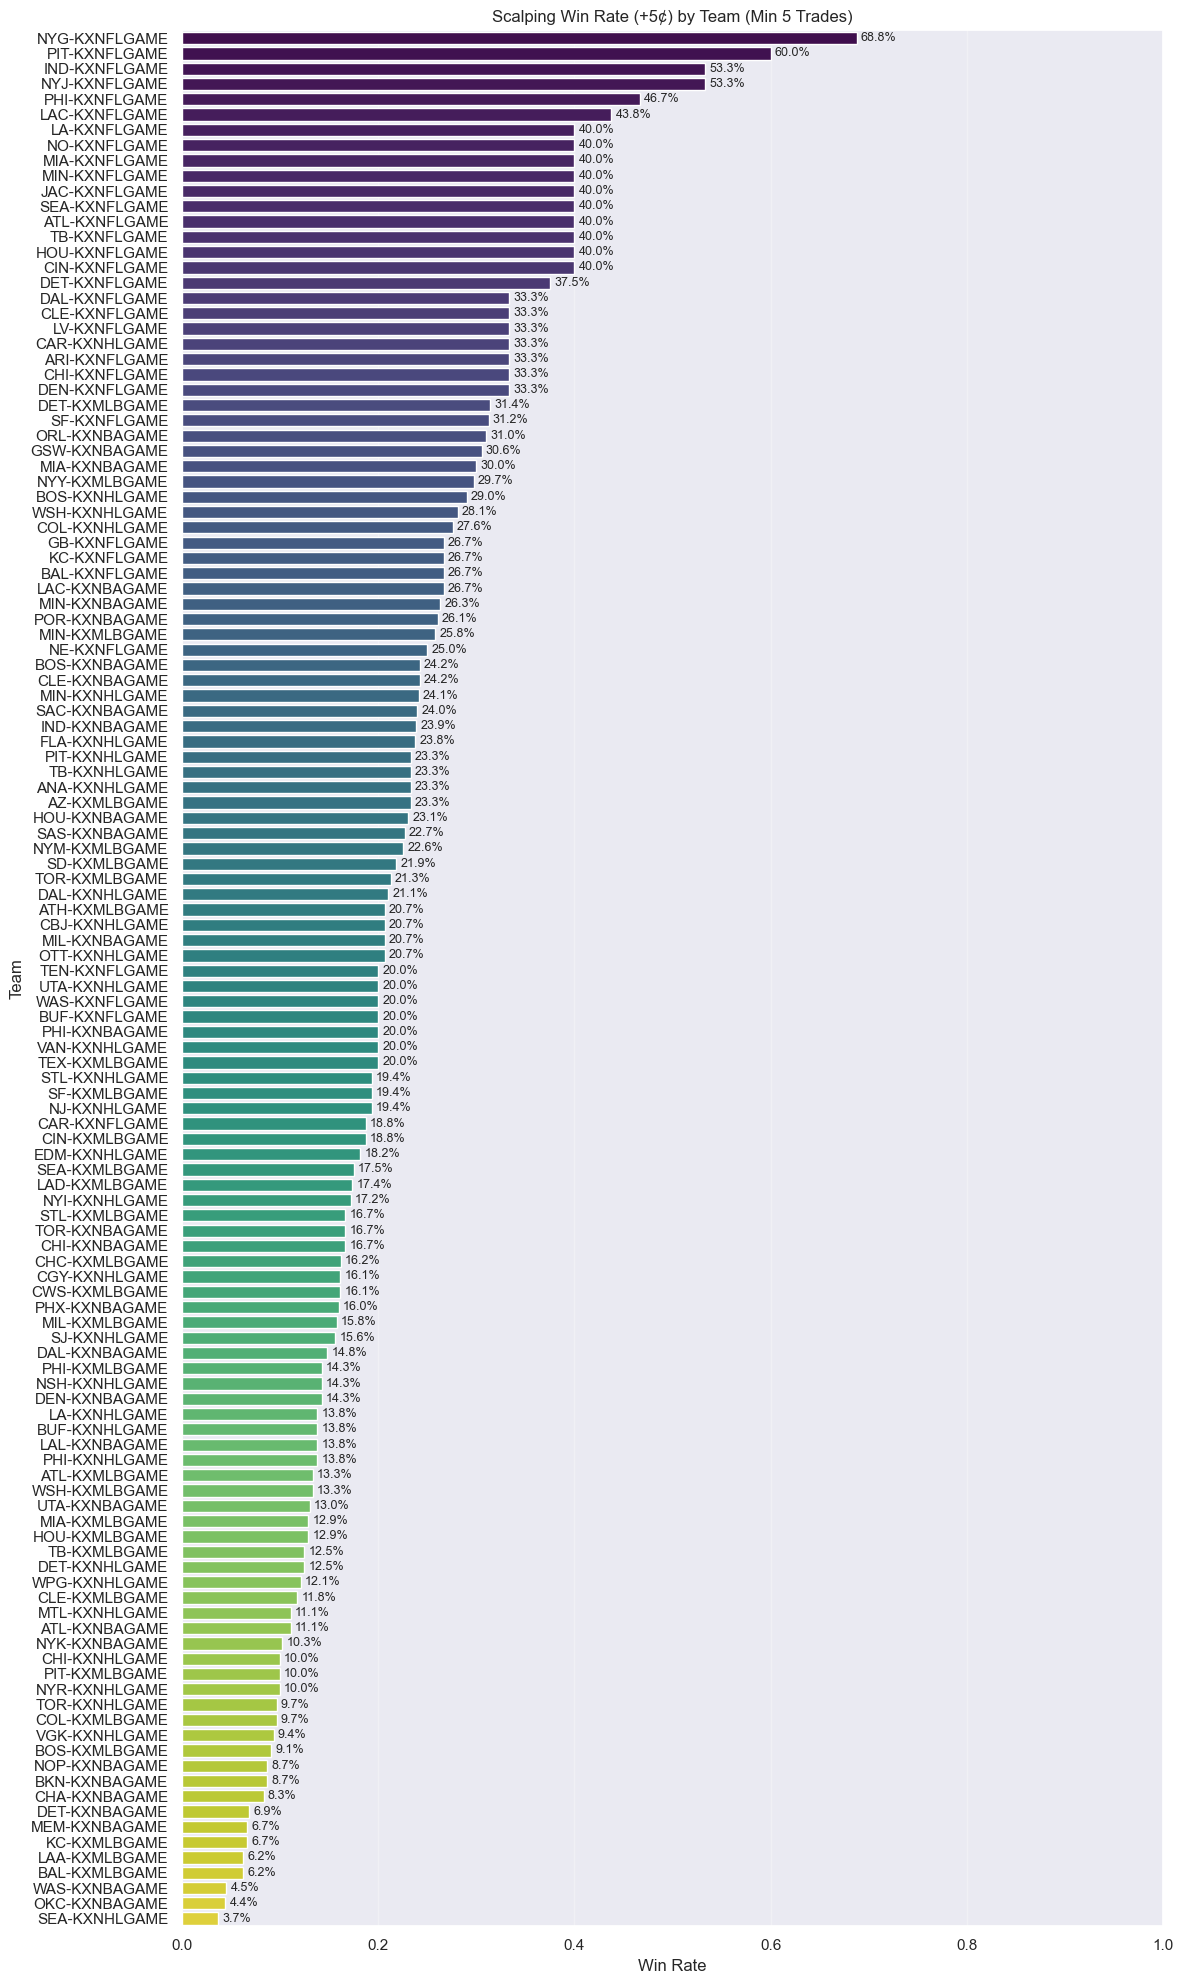

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_team_performance(df, min_trades=5):
    """
    Analyzes and graphs the win rate of scalping trades by team using the pre-processed DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with columns ['ticker', 'market', 'team', ... 'win_5c']
        min_trades (int): Minimum number of trades required for a team to be included.
    """

    if df.empty:
        print("Input DataFrame is empty.")
        return

    # 1. Aggregate Data by Team
    # We can group directly by the existing 'team' column
    team_stats = df.groupby('team').agg(
        trades=('win_5c', 'count'),
        win_rate=('win_5c', 'mean')
    ).reset_index()

    # 2. Filter out teams with too few trades
    team_stats = team_stats[team_stats['trades'] >= min_trades]

    # 3. Sort by Win Rate for better visualization
    team_stats = team_stats.sort_values(by='win_rate', ascending=False)

    print(f"Analyzing {len(team_stats)} teams with at least {min_trades} trades each.")

    if team_stats.empty:
        print(f"No teams found with >= {min_trades} trades.")
        return

    # 4. Plotting
    plt.figure(figsize=(12, 20))

    ax = sns.barplot(
        data=team_stats,
        y='team',
        x='win_rate',
        palette='viridis'
    )

    # Styling
    plt.title(f"Scalping Win Rate (+5¢) by Team (Min {min_trades} Trades)")
    plt.xlabel("Win Rate")
    plt.ylabel("Team")
    plt.xlim(0, 1.0)
    plt.grid(axis='x', alpha=0.3)

    # Add percentage labels
    for container in ax.containers:
        ax.bar_label(container, fmt='{:.1%}', padding=3, fontsize=9)

    plt.tight_layout()
    plt.show()

# --- USAGE ---
analyze_team_performance(df, min_trades=5)

Paired 3354 trades against their opponents.


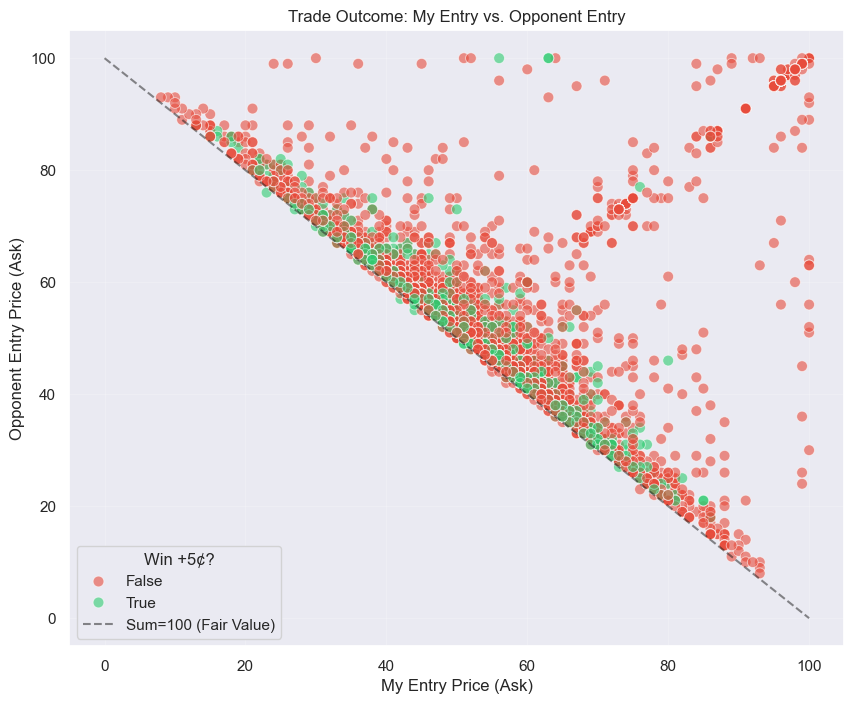

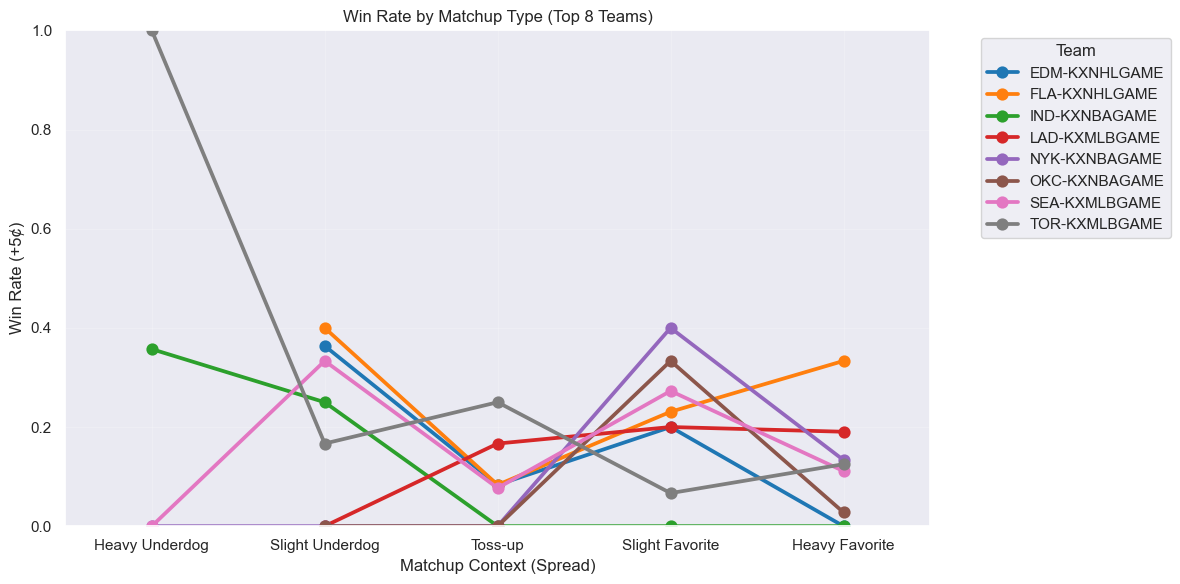

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def analyze_opponent_correlation(df):
    """
    Analyzes scalp win rates based on the relationship between a team's opening price
    and their opponent's opening price.

    Args:
        df (pd.DataFrame): DataFrame with columns ['market', 'team', 'open_price', 'win_5c', ...]
    """
    if df.empty:
        print("Input DataFrame is empty.")
        return

    # 1. Self-Merge to Find Opponents
    # We join the dataframe to itself on the 'market' column (the Game/Event ID).
    # This creates rows like: [Team A Data] + [Team B Data]
    df_paired = pd.merge(
        df,
        df,
        on='market',
        suffixes=('', '_opp')
    )

    # 2. Filter Logic
    # The merge creates pairings for (Team A vs Team A) and (Team A vs Team B).
    # We remove the self-matches and any potential duplicates.
    df_paired = df_paired[df_paired['team'] != df_paired['team_opp']].copy()

    if df_paired.empty:
        print("No paired data found. Ensure 'market' column is the unique Event ID.")
        return

    print(f"Paired {len(df_paired)} trades against their opponents.")

    # 3. Calculate "Spread" (My Price - Opponent Price)
    # Positive = I am Favorite. Negative = I am Underdog.
    df_paired['price_spread'] = df_paired['open_price'] - df_paired['open_price_opp']

    # Bin the spread for cleaner analysis
    # Bins: Heavy Underdog (<-20), Slight Underdog (-20 to -5), Toss-up (-5 to 5), etc.
    bins = [-100, -20, -5, 5, 20, 100]
    labels = ['Heavy Underdog', 'Slight Underdog', 'Toss-up', 'Slight Favorite', 'Heavy Favorite']
    df_paired['match_type'] = pd.cut(df_paired['price_spread'], bins=bins, labels=labels)

    # --- PLOT 1: GLOBAL PRICE CORRELATION ---
    plt.figure(figsize=(10, 8))

    sns.scatterplot(
        data=df_paired,
        x='open_price',
        y='open_price_opp',
        hue='win_5c',
        palette={True: '#2ecc71', False: '#e74c3c'},
        alpha=0.6,
        s=60
    )

    # Add "Zero Vig" Reference Line (x + y = 100)
    # Trades below this line are mathematically "cheap"
    x_line = np.linspace(0, 100, 100)
    y_line = 100 - x_line
    plt.plot(x_line, y_line, 'k--', label='Sum=100 (Fair Value)', alpha=0.5)

    plt.title("Trade Outcome: My Entry vs. Opponent Entry")
    plt.xlabel("My Entry Price (Ask)")
    plt.ylabel("Opponent Entry Price (Ask)")
    plt.legend(title="Win +5¢?")
    plt.grid(True, alpha=0.2)
    plt.show()

    # --- PLOT 2: TEAM SPECIFIC BREAKDOWN ---
    # We want to see if specific teams are better scalps when they are Underdogs vs Favorites.

    # Filter for top teams to keep graph readable
    top_teams = df_paired['team'].value_counts().nlargest(8).index
    df_subset = df_paired[df_paired['team'].isin(top_teams)]

    # Calculate win rate per Team per Match Type
    team_performance = df_subset.groupby(['team', 'match_type'])['win_5c'].mean().reset_index()

    plt.figure(figsize=(12, 6))

    sns.pointplot(
        data=team_performance,
        x='match_type',
        y='win_5c',
        hue='team',
        markers='o',
        linestyles='-',
        palette='tab10'
    )

    plt.title("Win Rate by Matchup Type (Top 8 Teams)")
    plt.xlabel("Matchup Context (Spread)")
    plt.ylabel("Win Rate (+5¢)")
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.2)
    plt.legend(title="Team", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- EXAMPLE USAGE ---
analyze_opponent_correlation(df)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_league_liquidity(data):
    """
    Visualizes average market liquidity (volume and open interest) across different sports leagues.

    Args:
        data (list): The nested list of market data dictionaries.
    """

    # 1. Helper to extract liquidity and league info
    def get_market_liquidity(market):
        ticker = market['ticker']
        # Extract Series/League from ticker (e.g., KXMLB-23SEP... -> KXMLB)
        series_ticker = ticker.split('-')[0]

        # Map series ticker to league name
        league_map = {
            'KXNBAGAME': 'NBA', # Handle specific series names if needed
            'KXNFLGAME': 'NFL',
            'KXMLBGAME': 'MLB',
            'KXNHLGAME': 'NHL'
        }

        # Simple fuzzy matching or direct mapping
        league = league_map.get(series_ticker, 'Other')

        # Or try to detect based on substring if mapping is incomplete
        if league == 'Other':
            if 'MLB' in series_ticker: league = 'MLB'
            elif 'NHL' in series_ticker: league = 'NHL'
            elif 'NFL' in series_ticker: league = 'NFL'
            elif 'NBA' in series_ticker: league = 'NBA'

        candles = market.get('candles', [])
        if not candles:
            return None

        # Calculate average volume and open interest for this market
        # We take the mean across all candles to represent the "typical" liquidity
        # Alternatively, you could take the max or sum depending on what "liquidity" means to you.
        # Here, we use the mean of Open Interest (standing contracts) and Sum of Volume (total activity).

        avg_open_interest = np.mean([c.get('open_interest', 0) for c in candles])
        total_volume = np.sum([c.get('volume', 0) for c in candles])

        return {
            'league': league,
            'ticker': ticker,
            'avg_open_interest': avg_open_interest,
            'total_volume': total_volume
        }

    # 2. Process all data
    all_markets = [m for sublist in data for m in sublist] if any(isinstance(i, list) for i in data) else data

    liquidity_data = []
    for m in all_markets:
        res = get_market_liquidity(m)
        if res:
            liquidity_data.append(res)

    df_league = pd.DataFrame(liquidity_data)

    if df_league.empty:
        print("No liquidity data found.")
        return

    # Filter out 'Other' if you only want the major leagues
    df_league = df_league[df_league['league'] != 'Other']

    # 3. Aggregation by League
    # We want the average liquidity *per market* in that league
    league_stats = df_league.groupby('league').agg(
        market_count=('ticker', 'count'),
        mean_open_interest=('avg_open_interest', 'mean'),
        mean_total_volume=('total_volume', 'mean')
    ).reset_index()

    # Sort for better visualization
    league_stats = league_stats.sort_values(by='mean_total_volume', ascending=False)

    print("League Liquidity Stats:")
    print(league_stats)

    # 4. Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Average Total Volume per Market
    sns.barplot(
        data=league_stats,
        x='league',
        y='mean_total_volume',
        palette='magma',
        ax=ax1
    )
    ax1.set_title("Average Trading Volume per Market")
    ax1.set_ylabel("Total Volume (Contracts)")
    ax1.set_xlabel("League")
    ax1.grid(axis='y', alpha=0.2)

    # Plot 2: Average Open Interest
    sns.barplot(
        data=league_stats,
        x='league',
        y='mean_open_interest',
        palette='viridis',
        ax=ax2
    )
    ax2.set_title("Average Open Interest per Market")
    ax2.set_ylabel("Avg Open Interest (Contracts)")
    ax2.set_xlabel("League")
    ax2.grid(axis='y', alpha=0.2)

    plt.tight_layout()
    plt.show()

# --- RUN THE FUNCTION ---
visualize_league_liquidity(data)